# Sistema de Detección de Fraude Crediticio Inmobiliario

## Objetivo del Proyecto
Detectar **solicitudes de crédito fraudulentas** mediante la identificación de patrones anómalos, inconsistencias y comportamientos sospechosos en solicitudes de préstamos inmobiliarios.

### Diferencia Clave
- **Impago (default)**: Cliente legítimo que no puede pagar
- **Fraude**: Solicitud con intención de engañar desde el inicio
- **Nuestro enfoque**: Detectar casos con alta probabilidad de ser fraudulentos para revisión humana

## 1. Configuración del Entorno

In [6]:
# Instalación automática de dependencias faltantes
import subprocess
import sys

def instalar_paquete(paquete):
    """Instalar paquete si no está disponible"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])
        return True
    except:
        return False


In [7]:
# Instalación automática de dependencias faltantes
import subprocess
import sys

def instalar_paquete(paquete):
    """Instalar paquete si no está disponible"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])
        return True
    except:
        return False

# Verificar e instalar dependencias críticas
dependencias_criticas = ['lightgbm', 'shap']
for dep in dependencias_criticas:
    try:
        __import__(dep)
    except ImportError:
        instalar_paquete(dep)

# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import (roc_auc_score, precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, roc_curve, confusion_matrix,
                           silhouette_score)

# Gradient Boosting (con alternativa si falla)
try:
    import lightgbm as lgb
    LIGHTGBM_DISPONIBLE = True
    print("LightGBM disponible")
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    LIGHTGBM_DISPONIBLE = False
    print("LightGBM no disponible - usando GradientBoostingClassifier de sklearn")

# Deep Learning (opcional)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    tf.random.set_seed(42)
    TENSORFLOW_DISPONIBLE = True
except ImportError:
    from sklearn.neural_network import MLPRegressor
    TENSORFLOW_DISPONIBLE = False

# Interpretabilidad (opcional)
try:
    import shap
    SHAP_DISPONIBLE = True
except ImportError:
    SHAP_DISPONIBLE = False

# Configuración general
import os
import gc
from typing import Tuple, Dict, List

SEMILLA_ALEATORIA = 42
np.random.seed(SEMILLA_ALEATORIA)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

c:\AA2 - Deteccion-de-fraude-inmobiliario\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LightGBM disponible


## 2. Carga y Exploración de Datos

In [8]:
# Carga de datos
RUTA_DATOS = r"C:\AA2 - Deteccion-de-fraude-inmobiliario\data\data"
df = pd.read_csv(os.path.join(RUTA_DATOS, "application_train.csv"))

# Información básica del dataset
distribucion = df['TARGET'].value_counts()
tasa_base = df['TARGET'].mean()

# Resumen de datos para referencia
info_dataset = {
    'dimensiones': df.shape,
    'distribucion_target': distribucion,
    'tasa_base_riesgo': tasa_base,
    'casos_sin_problemas': distribucion[0],
    'casos_con_problemas': distribucion[1] if 1 in distribucion else 0
}

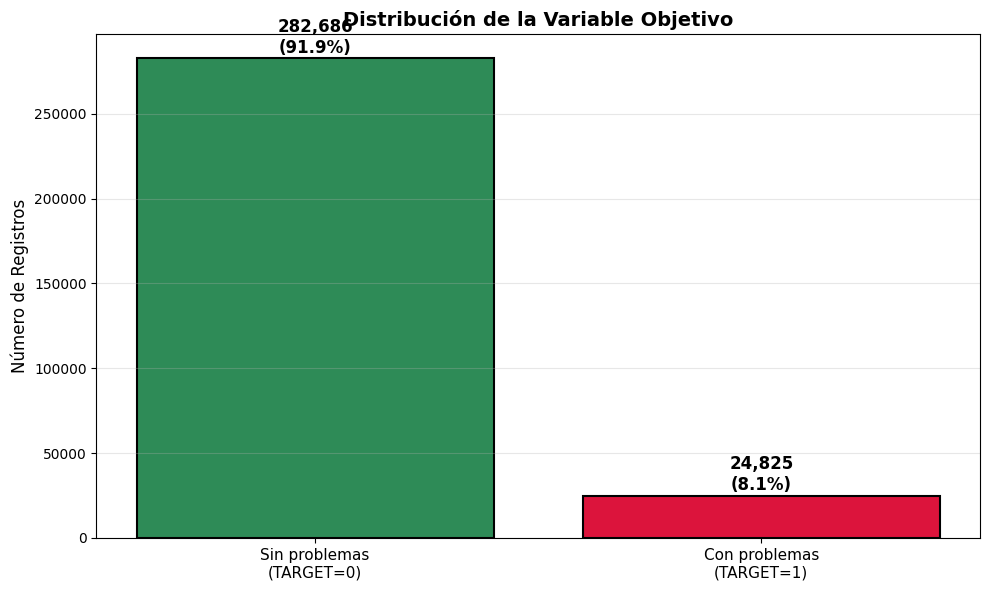

In [9]:
# Visualización de la distribución de TARGET
fig, ax = plt.subplots(figsize=(10, 6))

conteos = df['TARGET'].value_counts()
etiquetas = ['Sin problemas\n(TARGET=0)', 'Con problemas\n(TARGET=1)']
colores = ['#2E8B57', '#DC143C']

barras = ax.bar(range(len(conteos)), conteos.values, color=colores, edgecolor='black', linewidth=1.5)

for i, (barra, valor) in enumerate(zip(barras, conteos.values)):
    altura = barra.get_height()
    porcentaje = valor / len(df) * 100
    ax.text(barra.get_x() + barra.get_width()/2., altura + 1000,
            f'{valor:,}\n({porcentaje:.1f}%)', 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_ylabel('Número de Registros', fontsize=12)
ax.set_title('Distribución de la Variable Objetivo', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(etiquetas)))
ax.set_xticklabels(etiquetas, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [10]:
# Diccionario de traducción de variables a español
TRADUCCION_VARIABLES = {
    # Variables de montos
    'AMT_INCOME_TOTAL': 'INGRESO_TOTAL',
    'AMT_CREDIT': 'MONTO_CREDITO',
    'AMT_ANNUITY': 'ANUALIDAD',
    'AMT_GOODS_PRICE': 'PRECIO_BIENES',
    'AMT_DOWN_PAYMENT': 'PAGO_INICIAL',
    
    # Variables de tiempo
    'DAYS_BIRTH': 'DIAS_NACIMIENTO',
    'DAYS_EMPLOYED': 'DIAS_EMPLEO',
    'DAYS_REGISTRATION': 'DIAS_REGISTRO',
    'DAYS_ID_PUBLISH': 'DIAS_PUBLICACION_ID',
    'DAYS_LAST_PHONE_CHANGE': 'DIAS_CAMBIO_TELEFONO',
    
    # Variables de conteo
    'CNT_CHILDREN': 'NUM_HIJOS',
    'CNT_FAM_MEMBERS': 'NUM_FAMILIARES',
    
    # Variables de información personal
    'NAME_CONTRACT_TYPE': 'TIPO_CONTRATO',
    'CODE_GENDER': 'GENERO',
    'NAME_TYPE_SUITE': 'TIPO_ACOMPANANTE',
    'NAME_INCOME_TYPE': 'TIPO_INGRESO',
    'NAME_EDUCATION_TYPE': 'TIPO_EDUCACION',
    'NAME_FAMILY_STATUS': 'ESTADO_FAMILIAR',
    'NAME_HOUSING_TYPE': 'TIPO_VIVIENDA',
    'OCCUPATION_TYPE': 'TIPO_OCUPACION',
    
    # Variables de contacto
    'FLAG_MOBIL': 'TIENE_MOVIL',
    'FLAG_EMP_PHONE': 'TIENE_TELEFONO_TRABAJO',
    'FLAG_WORK_PHONE': 'TIENE_TELEFONO_OFICINA',
    'FLAG_CONT_MOBILE': 'CONTACTO_MOVIL',
    'FLAG_PHONE': 'TIENE_TELEFONO',
    'FLAG_EMAIL': 'TIENE_EMAIL',
    
    # Fuentes externas
    'EXT_SOURCE_1': 'FUENTE_EXTERNA_1',
    'EXT_SOURCE_2': 'FUENTE_EXTERNA_2',
    'EXT_SOURCE_3': 'FUENTE_EXTERNA_3',
    
    # Variables de región
    'REGION_POPULATION_RELATIVE': 'POBLACION_RELATIVA_REGION',
    'REGION_RATING_CLIENT': 'RATING_CLIENTE_REGION',
    'REGION_RATING_CLIENT_W_CITY': 'RATING_CLIENTE_CIUDAD',
    
    # Variable objetivo
    'TARGET': 'OBJETIVO'
}

def traducir_columnas(df, diccionario_traduccion):
    """Traduce nombres de columnas usando el diccionario"""
    return df.rename(columns=diccionario_traduccion)

# Análisis de variables numéricas clave
variables_clave = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
df_analisis = df[variables_clave + ['TARGET']].copy()

# Convertir días a años para mejor interpretación
df_analisis['EDAD'] = -df_analisis['DAYS_BIRTH'] / 365.25
df_analisis['ANOS_EMPLEO'] = -df_analisis['DAYS_EMPLOYED'] / 365.25

# Manejar valor especial en DAYS_EMPLOYED
df_analisis.loc[df['DAYS_EMPLOYED'] == 365243, 'ANOS_EMPLEO'] = np.nan

# Estadísticas descriptivas por TARGET
stats_resumen = {}
for var in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'EDAD']:
    if var in df_analisis.columns:
        stats_resumen[var] = df_analisis.groupby('TARGET')[var].describe().round(1)

## 3. Features para Detección de Fraude

En esta sección crearemos features específicas para identificar patrones fraudulentos:
- Inconsistencias en datos personales y laborales
- Ratios financieros sospechosos
- Patrones de comportamiento atípicos
- Señales de alerta de fraude conocidas

In [11]:
class ProcesadorDatos:
    def __init__(self, semilla=42, traducir_variables=True):
        self.semilla = semilla
        self.traducir_variables = traducir_variables
        self.imputador_num = SimpleImputer(strategy='median')
        self.imputador_cat = SimpleImputer(strategy='most_frequent')
        self.escalador = RobustScaler()
        self.codificadores = {}
        self.columnas_num = None
        self.columnas_cat = None
        self.mapeo_traduccion = {}
        
    def ajustar(self, X, y=None):
        # Identificar tipos de columnas
        self.columnas_num = X.select_dtypes(include=[np.number]).columns.tolist()
        self.columnas_cat = X.select_dtypes(include=['object']).columns.tolist()
        
        # Remover columnas ID
        self.columnas_num = [col for col in self.columnas_num if 'ID' not in col.upper()]
        
        # Ajustar imputadores
        if self.columnas_num:
            self.imputador_num.fit(X[self.columnas_num])
        if self.columnas_cat:
            self.imputador_cat.fit(X[self.columnas_cat])
            
        # Preparar codificadores para categóricas
        for col in self.columnas_cat:
            if col in X.columns:
                # Target encoding para alta cardinalidad
                if X[col].nunique() > 10 and y is not None:
                    # Crear DataFrame temporal para el cálculo
                    temp_df = pd.DataFrame({col: X[col], 'target': y})
                    media_target = temp_df.groupby(col)['target'].mean()
                    self.codificadores[col] = {'tipo': 'target', 'media': media_target, 
                                              'global': y.mean()}
                # Label encoding para baja cardinalidad
                else:
                    le = LabelEncoder()
                    le.fit(X[col].fillna('FALTANTE').astype(str))
                    self.codificadores[col] = {'tipo': 'label', 'encoder': le}
        return self
        
    def transformar(self, X):
        X_trans = X.copy()
        
        # Imputación (con nombres originales)
        if self.columnas_num:
            X_trans[self.columnas_num] = self.imputador_num.transform(X_trans[self.columnas_num])
        if self.columnas_cat:
            X_trans[self.columnas_cat] = self.imputador_cat.transform(X_trans[self.columnas_cat])
            
        # Codificación de categóricas (con nombres originales)
        for col in self.columnas_cat:
            if col in self.codificadores and col in X_trans.columns:
                if self.codificadores[col]['tipo'] == 'target':
                    # Target encoding: convertir a numérico
                    media = self.codificadores[col]['media']
                    global_mean = self.codificadores[col]['global']
                    X_trans[col] = X_trans[col].map(media).fillna(global_mean)
                else:
                    # Label encoding: convertir a numérico
                    le = self.codificadores[col]['encoder']
                    valores = X_trans[col].fillna('FALTANTE').astype(str)
                    X_trans[col] = valores.map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        
        # Eliminar categóricas restantes (por si quedara alguna)
        X_trans = X_trans.select_dtypes(include=[np.number])
        
        # Actualizar columnas numéricas finales
        columnas_num_finales = [col for col in self.columnas_num if col in X_trans.columns]
        
        # Escalado (con nombres originales)
        if columnas_num_finales:
            if not hasattr(self.escalador, 'scale_'):
                self.escalador.fit(X_trans[columnas_num_finales])
            X_trans[columnas_num_finales] = self.escalador.transform(X_trans[columnas_num_finales])
        
        # Aplicar traducción de variables AL FINAL si está habilitada
        if self.traducir_variables:
            X_trans = traducir_columnas(X_trans, TRADUCCION_VARIABLES)
            # Guardar mapeo para referencia futura
            self.mapeo_traduccion = {v: k for k, v in TRADUCCION_VARIABLES.items() if k in X.columns}
            
        return X_trans

# Crear muestra estratificada significativa (50k registros para rapidez)
TAMAÑO_MUESTRA = 50000  # Muestra representativa pero manejable

# Crear muestra estratificada manteniendo proporciones de TARGET
df_muestra = df.groupby('TARGET', group_keys=False).apply(
    lambda x: x.sample(min(len(x), int(TAMAÑO_MUESTRA * len(x) / len(df))), 
                      random_state=SEMILLA_ALEATORIA)
).reset_index(drop=True)

print(f"Dataset original: {len(df):,} registros")
print(f"Muestra estratificada: {len(df_muestra):,} registros ({len(df_muestra)/len(df)*100:.1f}%)")
print(f"Distribución original TARGET: {df['TARGET'].value_counts(normalize=True).values}")
print(f"Distribución muestra TARGET: {df_muestra['TARGET'].value_counts(normalize=True).values}")

# División estratificada del dataset muestreado
X = df_muestra.drop(['TARGET', 'SK_ID_CURR'], axis=1, errors='ignore')
y = df_muestra['TARGET']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEMILLA_ALEATORIA, stratify=y
)

# Crear conjunto de prueba desde validación
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=SEMILLA_ALEATORIA, stratify=y_val
)

# Aplicar preprocesamiento con traducción
procesador = ProcesadorDatos(SEMILLA_ALEATORIA, traducir_variables=True)
procesador.ajustar(X_train, y_train)

X_train_proc = procesador.transformar(X_train)
X_val_proc = procesador.transformar(X_val)
X_test_proc = procesador.transformar(X_test)

# Resumen de preprocesamiento
resumen_preprocesamiento = {
    'registros_entrenamiento': len(X_train),
    'registros_validacion': len(X_val),
    'registros_prueba': len(X_test),
    'features_originales': X_train.shape[1],
    'features_procesadas': X_train_proc.shape[1],
    'variables_traducidas': len([k for k in TRADUCCION_VARIABLES.keys() if k in X_train.columns])
}

print(f"Features después del preprocesamiento: {X_train_proc.shape[1]}")
print(f"Variables traducidas: {resumen_preprocesamiento['variables_traducidas']}")
print(f"División: {len(X_train)} entrenamiento, {len(X_val)} validación, {len(X_test)} prueba")

Dataset original: 307,511 registros
Muestra estratificada: 49,999 registros (16.3%)
Distribución original TARGET: [0.91927118 0.08072882]
Distribución muestra TARGET: [0.91927839 0.08072161]
Features después del preprocesamiento: 120
Variables traducidas: 31
División: 39999 entrenamiento, 5000 validación, 5000 prueba
Features después del preprocesamiento: 120
Variables traducidas: 31
División: 39999 entrenamiento, 5000 validación, 5000 prueba


## 4. Construcción de Reglas de Negocio e Índices de Ambigüedad

In [12]:
class GeneradorReglasNegocio:
    def __init__(self):
        self.umbrales = {}
        self.reglas_aplicadas = []
        
    def calibrar_umbrales(self, df_train):
        """Calibrar umbrales basados en datos de entrenamiento"""
        
        # Umbral para ratio crédito/ingreso
        if 'AMT_CREDIT' in df_train.columns and 'AMT_INCOME_TOTAL' in df_train.columns:
            ratio_credito_ingreso = df_train['AMT_CREDIT'] / (df_train['AMT_INCOME_TOTAL'] + 1)
            self.umbrales['ratio_credito_alto'] = ratio_credito_ingreso.quantile(0.95)
            
        # Umbral para ratio anualidad/ingreso  
        if 'AMT_ANNUITY' in df_train.columns and 'AMT_INCOME_TOTAL' in df_train.columns:
            ratio_anualidad_ingreso = df_train['AMT_ANNUITY'] / (df_train['AMT_INCOME_TOTAL'] + 1)
            self.umbrales['ratio_anualidad_alto'] = ratio_anualidad_ingreso.quantile(0.90)
            
        # Umbral para ingreso bajo
        if 'AMT_INCOME_TOTAL' in df_train.columns:
            self.umbrales['ingreso_bajo'] = df_train['AMT_INCOME_TOTAL'].quantile(0.20)
            
        return self
        
    def generar_reglas(self, df):
        """Generar flags de ambigüedad basados en reglas de negocio"""
        
        reglas_df = pd.DataFrame(index=df.index)
        
        # REGLA 1: Edad fuera de rango normal (menor 18 o mayor 80 años)
        if 'DAYS_BIRTH' in df.columns:
            edad_anos = -df['DAYS_BIRTH'] / 365.25
            reglas_df['AMB_EDAD_EXTREMA'] = ((edad_anos < 18) | (edad_anos > 80)).astype(int)
            self.reglas_aplicadas.append('AMB_EDAD_EXTREMA: Edad menor a 18 o mayor a 80 años')
            
        # REGLA 2: Días empleado con valor especial (indicador de datos faltantes)
        if 'DAYS_EMPLOYED' in df.columns:
            reglas_df['AMB_EMPLEO_FALTANTE'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
            self.reglas_aplicadas.append('AMB_EMPLEO_FALTANTE: DAYS_EMPLOYED con valor especial 365243')
            
        # REGLA 3: Antigüedad laboral inconsistente con edad
        if 'DAYS_BIRTH' in df.columns and 'DAYS_EMPLOYED' in df.columns:
            edad_anos = -df['DAYS_BIRTH'] / 365.25
            anos_empleo = -df['DAYS_EMPLOYED'] / 365.25
            # Solo considerar casos con empleo válido
            mask_empleo_valido = df['DAYS_EMPLOYED'] != 365243
            edad_laboral_minima = edad_anos - 16  # Asumiendo edad mínima laboral 16 años
            inconsistencia = mask_empleo_valido & (anos_empleo > edad_laboral_minima)
            reglas_df['AMB_EMPLEO_INCONSISTENTE'] = inconsistencia.astype(int)
            self.reglas_aplicadas.append('AMB_EMPLEO_INCONSISTENTE: Antigüedad laboral mayor a edad laboral posible')
            
        # REGLA 4: Ratio crédito/ingreso sospechosamente alto
        if ('AMT_CREDIT' in df.columns and 'AMT_INCOME_TOTAL' in df.columns and 
            'ratio_credito_alto' in self.umbrales):
            ratio_credito = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
            reglas_df['AMB_RATIO_CREDITO_ALTO'] = (
                ratio_credito > self.umbrales['ratio_credito_alto']
            ).astype(int)
            self.reglas_aplicadas.append(f'AMB_RATIO_CREDITO_ALTO: Ratio crédito/ingreso > {self.umbrales["ratio_credito_alto"]:.2f}')
            
        # REGLA 5: Familia vulnerable (muchos hijos + ingreso bajo)
        if ('CNT_CHILDREN' in df.columns and 'AMT_INCOME_TOTAL' in df.columns and
            'ingreso_bajo' in self.umbrales):
            reglas_df['AMB_FAMILIA_VULNERABLE'] = (
                (df['CNT_CHILDREN'] >= 3) & 
                (df['AMT_INCOME_TOTAL'] <= self.umbrales['ingreso_bajo'])
            ).astype(int)
            self.reglas_aplicadas.append(f'AMB_FAMILIA_VULNERABLE: 3+ hijos con ingreso <= {self.umbrales["ingreso_bajo"]:,.0f}')
            
        # REGLA 6: Información de contacto limitada
        columnas_contacto = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL']
        cols_disponibles = [col for col in columnas_contacto if col in df.columns]
        if cols_disponibles:
            suma_contacto = df[cols_disponibles].sum(axis=1)
            reglas_df['AMB_CONTACTO_LIMITADO'] = (suma_contacto <= 1).astype(int)
            self.reglas_aplicadas.append('AMB_CONTACTO_LIMITADO: Solo 1 o menos medios de contacto')
            
        # REGLA 7: Fuentes externas completamente faltantes
        columnas_ext = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
        cols_ext_disponibles = [col for col in columnas_ext if col in df.columns]
        if cols_ext_disponibles:
            ext_faltantes = df[cols_ext_disponibles].isnull().sum(axis=1)
            reglas_df['AMB_SIN_FUENTES_EXTERNAS'] = (
                ext_faltantes == len(cols_ext_disponibles)
            ).astype(int)
            self.reglas_aplicadas.append('AMB_SIN_FUENTES_EXTERNAS: Todas las fuentes externas faltantes')
        
        # Calcular Índice de Ambigüedad (IA) con pesos calibrados
        columnas_ambiguedad = [col for col in reglas_df.columns if col.startswith('AMB_')]
        
        if columnas_ambiguedad:
            # Pesos basados en severidad e impacto en el negocio
            pesos = {
                'AMB_EDAD_EXTREMA': 3.0,                # Muy crítico - datos imposibles
                'AMB_EMPLEO_INCONSISTENTE': 2.5,        # Crítico - inconsistencia temporal
                'AMB_RATIO_CREDITO_ALTO': 2.0,          # Alto - indicador financiero
                'AMB_FAMILIA_VULNERABLE': 1.5,          # Medio - factor socioeconómico
                'AMB_EMPLEO_FALTANTE': 1.0,             # Medio - calidad de datos
                'AMB_CONTACTO_LIMITADO': 1.0,           # Medio - verificabilidad
                'AMB_SIN_FUENTES_EXTERNAS': 0.5         # Bajo - información complementaria
            }
            
            # Calcular IA como suma ponderada
            ia_score = pd.Series(0.0, index=reglas_df.index)
            for columna in columnas_ambiguedad:
                peso = pesos.get(columna, 1.0)
                ia_score += reglas_df[columna] * peso
                
            reglas_df['IA'] = ia_score
            
        return reglas_df

# Aplicar reglas de negocio
generador_reglas = GeneradorReglasNegocio()
generador_reglas.calibrar_umbrales(X_train)

# Generar reglas para todos los conjuntos
reglas_train = generador_reglas.generar_reglas(X_train)
reglas_val = generador_reglas.generar_reglas(X_val)
reglas_test = generador_reglas.generar_reglas(X_test)

# Resumen de reglas aplicadas
reglas_aplicadas_resumen = {
    'total_reglas': len(generador_reglas.reglas_aplicadas),
    'reglas_detalle': generador_reglas.reglas_aplicadas,
    'estadisticas_ia': reglas_train['IA'].describe().round(2)
}

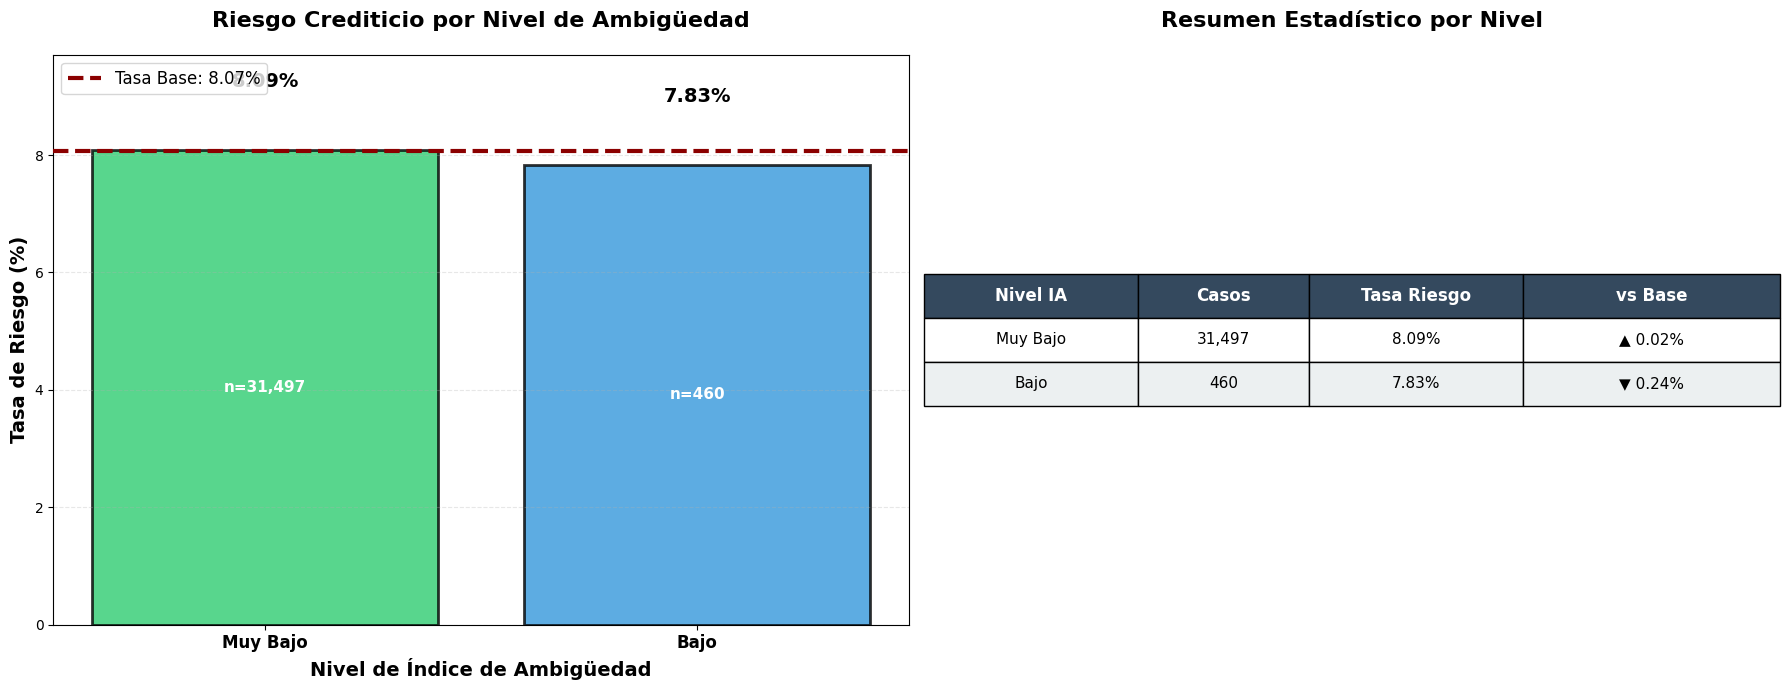


RESUMEN DEL ÍNDICE DE AMBIGÜEDAD
Tasa base de riesgo: 8.07%
Nivel con mayor riesgo: Muy Bajo (8.09%)
Nivel con menor riesgo: Bajo (7.83%)



In [13]:
# Visualización mejorada: Tasa de riesgo por nivel de Índice de Ambigüedad
datos_combinados = pd.concat([reglas_train, y_train.reset_index(drop=True)], axis=1)

# Discretizar IA en 5 grupos para mejor visualización
ia_bins = pd.qcut(datos_combinados['IA'], q=5, duplicates='drop')
analisis_ia = datos_combinados.groupby(ia_bins).agg({
    'TARGET': ['mean', 'count']
}).round(4)
analisis_ia.columns = ['Tasa_Riesgo', 'Conteo']

# Crear etiquetas según el número real de bins
niveles_labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']
num_bins = len(analisis_ia)
if num_bins < 5:
    niveles_labels = niveles_labels[:num_bins]
analisis_ia.index = niveles_labels

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# GRÁFICO 1: Barras con tasa de riesgo
colores_map = {
    'Muy Bajo': '#2ecc71',
    'Bajo': '#3498db', 
    'Medio': '#f39c12',
    'Alto': '#e74c3c',
    'Muy Alto': '#c0392b'
}
colores = [colores_map.get(label, '#95a5a6') for label in niveles_labels]

barras = ax1.bar(range(len(analisis_ia)), analisis_ia['Tasa_Riesgo'] * 100, 
                 color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Línea de referencia
tasa_base = datos_combinados['TARGET'].mean() * 100
ax1.axhline(y=tasa_base, color='darkred', linestyle='--', linewidth=3,
            label=f'Tasa Base: {tasa_base:.2f}%', zorder=5)

# Etiquetas en barras
for i, (barra, (idx, row)) in enumerate(zip(barras, analisis_ia.iterrows())):
    altura = barra.get_height()
    # Porcentaje
    ax1.text(barra.get_x() + barra.get_width()/2., altura + 1,
             f'{altura:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')
    # Conteo
    ax1.text(barra.get_x() + barra.get_width()/2., altura/2,
             f'n={int(row["Conteo"]):,}', ha='center', va='center', 
             fontsize=11, color='white', fontweight='bold')

ax1.set_xlabel('Nivel de Índice de Ambigüedad', fontsize=14, fontweight='bold')
ax1.set_ylabel('Tasa de Riesgo (%)', fontsize=14, fontweight='bold')
ax1.set_title('Riesgo Crediticio por Nivel de Ambigüedad', fontsize=16, fontweight='bold', pad=20)
ax1.set_xticks(range(len(analisis_ia)))
ax1.set_xticklabels(analisis_ia.index, fontsize=12, fontweight='bold')
ax1.legend(fontsize=12, loc='upper left')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
ax1.set_ylim(0, max(analisis_ia['Tasa_Riesgo'] * 100) * 1.2)

# GRÁFICO 2: Tabla resumen
ax2.axis('tight')
ax2.axis('off')

# Preparar datos para tabla
tabla_datos = []
for idx, row in analisis_ia.iterrows():
    tasa_pct = row['Tasa_Riesgo'] * 100
    diferencia = tasa_pct - tasa_base
    simbolo = '▲' if diferencia > 0 else '▼' if diferencia < 0 else '='
    
    tabla_datos.append([
        str(idx),
        f"{int(row['Conteo']):,}",
        f"{tasa_pct:.2f}%",
        f"{simbolo} {abs(diferencia):.2f}%"
    ])

tabla = ax2.table(cellText=tabla_datos,
                  colLabels=['Nivel IA', 'Casos', 'Tasa Riesgo', 'vs Base'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.25, 0.2, 0.25, 0.3])

tabla.auto_set_font_size(False)
tabla.set_fontsize(11)
tabla.scale(1, 2.5)

# Estilo de encabezados
for i in range(4):
    tabla[(0, i)].set_facecolor('#34495e')
    tabla[(0, i)].set_text_props(weight='bold', color='white', fontsize=12)

# Estilo de celdas
for i in range(1, len(tabla_datos) + 1):
    for j in range(4):
        if i % 2 == 0:
            tabla[(i, j)].set_facecolor('#ecf0f1')
        tabla[(i, j)].set_text_props(fontsize=11)

ax2.set_title('Resumen Estadístico por Nivel', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"RESUMEN DEL ÍNDICE DE AMBIGÜEDAD")
print(f"{'='*70}")
print(f"Tasa base de riesgo: {tasa_base:.2f}%")
print(f"Nivel con mayor riesgo: {analisis_ia['Tasa_Riesgo'].idxmax()} ({analisis_ia['Tasa_Riesgo'].max()*100:.2f}%)")
print(f"Nivel con menor riesgo: {analisis_ia['Tasa_Riesgo'].idxmin()} ({analisis_ia['Tasa_Riesgo'].min()*100:.2f}%)")
print(f"{'='*70}\n")

analisis_deciles_ia = analisis_ia.copy()

# Visualización: Distribución de scores de anomalía por TARGET incluyendo t-SNE
datos_viz = pd.concat([anomalias_train, y_train.reset_index(drop=True)], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

scores_analizar = ['ERROR_RECONSTRUCCION', 'SCORE_ISOLATION', 'SCORE_LOF', 'SCORE_TSNE_CLUSTER']
titulos = ['Error de Reconstrucción (Autoencoder)', 'Score Isolation Forest', 
           'Score Local Outlier Factor', 'Score t-SNE Clustering']

for i, (score_col, titulo) in enumerate(zip(scores_analizar, titulos)):
    scores_target_0 = datos_viz[datos_viz['TARGET']==0][score_col]
    scores_target_1 = datos_viz[datos_viz['TARGET']==1][score_col]
    
    axes[i].hist(scores_target_0, bins=50, alpha=0.7, label='TARGET=0 (Sin problemas)', 
                density=True, color='steelblue')
    axes[i].hist(scores_target_1, bins=50, alpha=0.7, label='TARGET=1 (Con problemas)', 
                density=True, color='coral')
    
    axes[i].set_title(titulo, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Score Normalizado')
    axes[i].set_ylabel('Densidad')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de correlación con TARGET
print("Correlación de features de anomalía con TARGET:")
for col in scores_analizar:
    corr = datos_viz[col].corr(datos_viz['TARGET'])
    print(f"  {col}: {corr:.4f}")


Análisis detallado del Índice de Ambigüedad (IA):
Efectividad por quintiles del Índice de Ambigüedad (IA):
           Tasa_Riesgo  Total_Casos  Casos_Positivos
Q1 (Bajo)        0.081        31497           2547.0
Q2 (Alto)        0.078          460             36.0


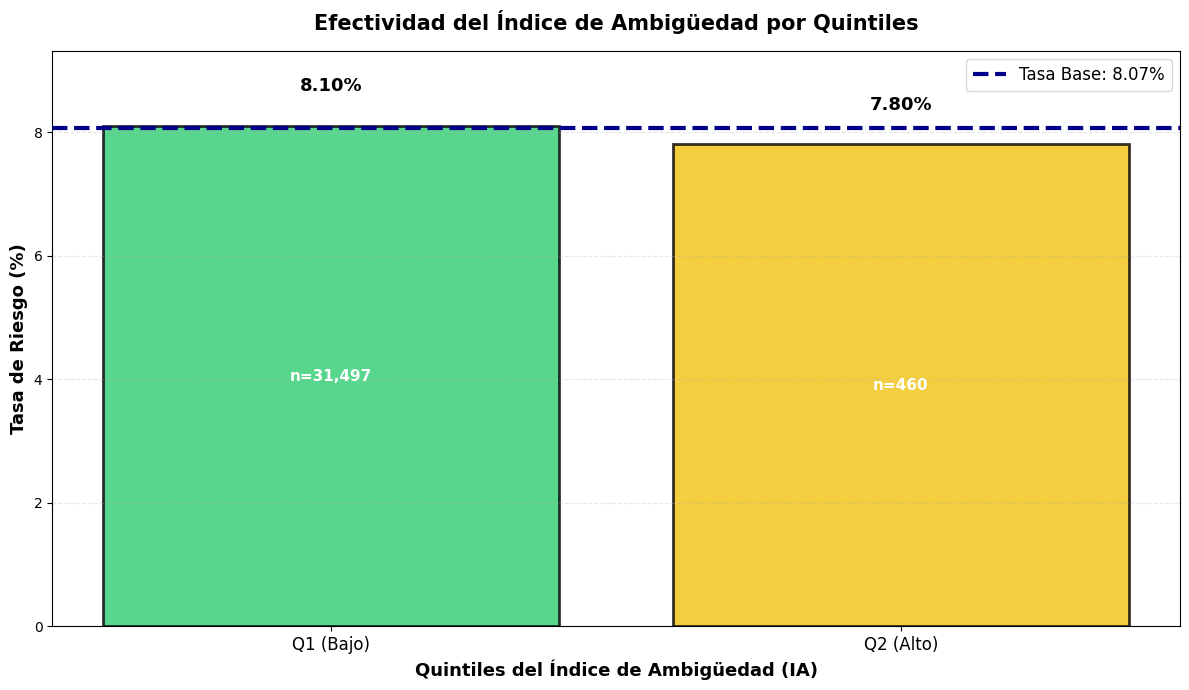


MÉTRICAS DE EFECTIVIDAD ÍNDICE DE AMBIGÜEDAD (IA)
Lift del quintil más alto: 0.97x
Concentración de casos de riesgo en Q2 (Alto): 1.1%
Tasa de riesgo Q2 (Alto): 7.80%
Tasa de riesgo Q1 (Bajo): 8.10%
Ratio Alto/Bajo: 0.96x



In [14]:
# Análisis de efectividad del Índice de Ambigüedad (IA)

# Verificar que reglas_train existe
if 'reglas_train' not in locals() and 'reglas_train' not in globals():
    print("ERROR: Se necesita ejecutar la celda de generación de reglas de negocio primero")
    raise ValueError("La variable 'reglas_train' no está disponible. Ejecuta la celda anterior primero.")

# Crear datos para análisis combinando IA con TARGET
datos_viz = pd.concat([reglas_train[['IA']], y_train.reset_index(drop=True)], axis=1)

print("\nAnálisis detallado del Índice de Ambigüedad (IA):")

# Discretizar IA en quintiles para análisis
score_ia = datos_viz['IA']
quintiles = pd.qcut(score_ia, q=5, duplicates='drop')

analisis_quintiles = datos_viz.groupby(quintiles).agg({
    'TARGET': ['mean', 'count', 'sum']
}).round(3)
analisis_quintiles.columns = ['Tasa_Riesgo', 'Total_Casos', 'Casos_Positivos']

# Crear etiquetas dinámicas según el número real de bins
quintiles_labels = ['Q1 (Bajo)', 'Q2', 'Q3', 'Q4', 'Q5 (Alto)']
num_quintiles = len(analisis_quintiles)
if num_quintiles < 5:
    quintiles_labels = [f'Q{i+1}' for i in range(num_quintiles)]
    quintiles_labels[0] = f'{quintiles_labels[0]} (Bajo)'
    quintiles_labels[-1] = f'{quintiles_labels[-1]} (Alto)'
analisis_quintiles.index = quintiles_labels

print("Efectividad por quintiles del Índice de Ambigüedad (IA):")
print(analisis_quintiles)

# Crear gráfico de barras para visualizar efectividad
fig, ax = plt.subplots(figsize=(12, 7))

# Colores adaptativos según número de quintiles
colores_base = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#c0392b']
colores = colores_base[:num_quintiles]

x_pos = range(len(analisis_quintiles))
barras = ax.bar(x_pos, analisis_quintiles['Tasa_Riesgo'] * 100, 
               color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Línea de referencia con tasa base
tasa_base = datos_viz['TARGET'].mean()
ax.axhline(y=tasa_base * 100, color='darkblue', linestyle='--', linewidth=3,
           label=f'Tasa Base: {tasa_base*100:.2f}%', zorder=5)

# Añadir etiquetas con conteos y porcentajes
for barra, (idx, row) in zip(barras, analisis_quintiles.iterrows()):
    altura = barra.get_height()
    # Porcentaje arriba
    ax.text(barra.get_x() + barra.get_width()/2., altura + 0.5,
            f'{altura:.2f}%', ha='center', va='bottom', fontsize=13, fontweight='bold')
    # Conteo dentro
    ax.text(barra.get_x() + barra.get_width()/2., altura/2,
            f'n={int(row["Total_Casos"]):,}', ha='center', va='center', 
            fontsize=11, color='white', fontweight='bold')

ax.set_xlabel('Quintiles del Índice de Ambigüedad (IA)', fontsize=13, fontweight='bold')
ax.set_ylabel('Tasa de Riesgo (%)', fontsize=13, fontweight='bold')
ax.set_title('Efectividad del Índice de Ambigüedad por Quintiles', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(analisis_quintiles.index, rotation=0, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim(0, max(analisis_quintiles['Tasa_Riesgo'] * 100) * 1.15)

plt.tight_layout()
plt.show()

# Calcular lift del IA
lift_ia = analisis_quintiles['Tasa_Riesgo'].iloc[-1] / tasa_base
concentracion = analisis_quintiles['Casos_Positivos'].iloc[-1] / datos_viz['TARGET'].sum()

print(f"\n{'='*60}")
print(f"MÉTRICAS DE EFECTIVIDAD ÍNDICE DE AMBIGÜEDAD (IA)")
print(f"{'='*60}")
print(f"Lift del quintil más alto: {lift_ia:.2f}x")
print(f"Concentración de casos de riesgo en {quintiles_labels[-1]}: {concentracion:.1%}")
print(f"Tasa de riesgo {quintiles_labels[-1]}: {analisis_quintiles['Tasa_Riesgo'].iloc[-1]*100:.2f}%")
print(f"Tasa de riesgo {quintiles_labels[0]}: {analisis_quintiles['Tasa_Riesgo'].iloc[0]*100:.2f}%")
print(f"Ratio Alto/Bajo: {analisis_quintiles['Tasa_Riesgo'].iloc[-1] / analisis_quintiles['Tasa_Riesgo'].iloc[0]:.2f}x")
print(f"{'='*60}\n")